# Plots for experiments with different intervention strengths

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
import scipy
from src import utils
import pickle

### Path to result files

In [2]:
# Experiments to load

experiments = [
    
    ["experiments/results_1589225762_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:3.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.0001.pickle"],
    ["experiments/results_1589224906_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:5.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.0001.pickle"],
    ["experiments/results_1589225245_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:7.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.0001.pickle"],
    ["experiments/results_1589225236_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:3.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.0002.pickle"],
    ["experiments/results_1589223144_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:5.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.0002.pickle"],
    ["experiments/results_1589223259_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:7.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.0002.pickle"],
    ["experiments/results_1590691693_runs:4_max_iter:50_tag:may28weak_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:3.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.001.pickle"],
    ["experiments/results_1590697825_runs:4_max_iter:50_tag:may28med_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:5.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.001.pickle"],
    ["experiments/results_1590705616_runs:4_max_iter:50_tag:may28strng_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:7.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.001.pickle"],
    ["experiments/results_1589225031_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:3.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.002.pickle"],
    ["experiments/results_1589225154_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:5.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.002.pickle"],
    ["experiments/results_1589225064_runs:4_max_iter:50_tag:may11abcd_load_dataset:dataset_3_abcd:True_G:4_do:False_i_mean:7.0_i_var:1.0_finite:True_n:10_n_obs:100_alpha:0.002.pickle"],
]

### Plotting setup

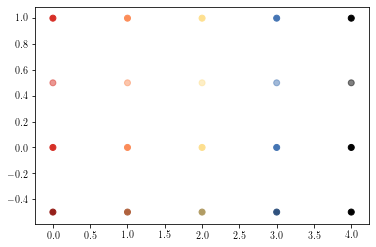

In [3]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ['#d73027', '#fc8d59', '#fee090', '#4575b4', '#020202',]
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
#base = [base[i] for i in [0,1,3]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

### Load and process data

In [4]:
def jaccard_sim(A,B):
    A = set(A) if type(A) is not set else A
    B = set(B) if type(B) is not set else B
    return len(A & B) / len(A | B)

In [5]:
# Code to load (and possibly merge) results from several files, as experiments can be submitted to Euler in different jobs to reduce time

def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i].copy()
    else:
        raise Exception("Cannot merge")
    return old

def load_results(filenames):
    cases, results = load_experiments(filenames[0])
    for filename in filenames[1::]:
        print("Loading %s" % filename)
        new_cases, new_results = load_experiments(filename)
        cases += new_cases
        for k in range(len(results)):
            results[k] = merge_runs(results[k], new_results[k])
    print("\nLoaded a total of %d graphs with %d runs each" % (len(results[0][0]), len(results[0])))
    return cases, results

In [6]:
def generate_trajectories(results, cases):
    runs = len(results[0])
    N = len(results[0][0])
    P = len(results)


    no_ints = np.zeros((len(results), runs, N))
    all_trajectories = {}
    all_type1_errors = {}
    all_empty_pool_events = {}
    names = []
    for k, policy_runs in enumerate(results):
        name = policy_runs[0][0].policy
        print("Processing results for %s policy" % name, end="")
        names.append(name)
        trajectories = []
        type1_errors = []
        empty_pool_events = []
        for i,run_results in enumerate(policy_runs):
            for j, result in enumerate(run_results):
                # add final result to history of estimates
                estimates = result.estimates() + [result.estimate]
                try:
                    # checks whether truth is contained in estimates and retrieves index
                    no_ints[k, i, j] = estimates.index(cases[j].truth)
                except ValueError:
                    # if not, add max. intervention number
                    no_ints[k, i, j] = len(result.interventions())
                trajectory = list(map(lambda estimate: jaccard_sim(cases[j].truth, estimate), estimates))
                type1_error = list(map(lambda estimate: set.issubset(estimate, cases[j].truth), estimates))
                trajectories.append(trajectory)
                type1_errors.append(type1_error)
                empty_pool_events.append(result.empty_pool)
        all_trajectories[name] = trajectories
        all_type1_errors[name] = type1_errors
        all_empty_pool_events[name] = empty_pool_events
        print(" done")
    return all_trajectories, all_type1_errors, all_empty_pool_events, N, P, runs, names, no_ints

In [7]:
def process_experiments(experiments):
    Trajectories = []
    Type1Errors = []
    NoInts = []
    EmptyPoolEvents = []
    
    for i,filenames in enumerate(experiments):
        print("\n\n %d/%d" % (i+1, len(experiments)), end=" ")
        cases, results = load_results(filenames)
        trajectories, type1_errors, empty_pool_events, N, P, runs, names, no_ints = generate_trajectories(results, cases)
        if i==0:
            prev_N, prev_P, prev_runs = N, P, runs
        elif prev_N != N or prev_P != P or prev_runs != runs:
            print(N, P, runs)
            print(prev_N, prev_P, prev_runs)
            print("Experiments have different number of graphs / policies / runs")
        Trajectories.append(trajectories)
        Type1Errors.append(type1_errors)
        NoInts.append(no_ints)
        EmptyPoolEvents.append(empty_pool_events)
    return Trajectories, Type1Errors, NoInts, EmptyPoolEvents, N, P, runs, names, cases

In [8]:
Trajectories, Type1Errors, NoInts, EmptyPoolEvents, N, P, runs, names, cases = process_experiments(experiments)



 1/12 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e + r policy done
Processing results for e policy done
Processing results for r policy done


 2/12 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e + r policy done
Processing results for e policy done
Processing results for r policy done


 3/12 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e + r policy done
Processing results for e policy done
Processing results for r policy done


 4/12 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e + r policy done
Processing results for e policy done
Processing results for r policy done


 5/12 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e + r policy done
Processing res

### Summary of graphs used

100 graphs in total


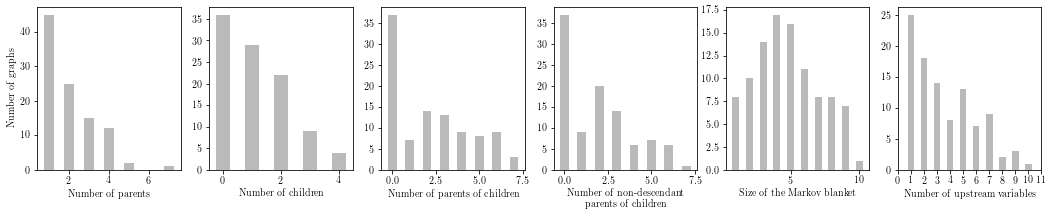

In [9]:
n_parents = np.zeros(N)
n_children = np.zeros(N)
n_poc = np.zeros(N)
n_ndesc_poc = np.zeros(N)
n_upstream = np.zeros(N)
size_mb = np.zeros(N)
for i, case in enumerate(cases):
    parents, children, poc, mb = utils.graph_info(case.target, case.sem.W)
    ancestors = utils.ancestors(case.target, case.sem.W)
    descendants = utils.descendants(case.target, case.sem.W)
    n_parents[i] = len(parents)
    n_children[i] = len(children)
    n_poc[i] = len(poc)
    n_ndesc_poc[i] = len(poc - descendants)
    n_upstream[i] = len(ancestors)
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid', color="#BABABA")#colorsb[2])
    plt.xlabel(title)
    
plt.figure(figsize=(18,3))
#plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(161), plot_hist(n_parents, "Number of parents"), plt.ylabel("Number of graphs")
plt.subplot(162), plot_hist(n_children, "Number of children")
plt.subplot(163), plot_hist(n_poc, "Number of parents of children")
plt.subplot(164), plot_hist(n_ndesc_poc, "Number of non-descendant\nparents of children")
plt.subplot(165), plot_hist(size_mb, "Size of the Markov blanket")
plt.subplot(166), plot_hist(n_upstream, "Number of upstream variables")
ax = plt.gca()
ax.set_xticks(range(12))

print("%d graphs in total" % N)

### Graph selection: Plot results only for particular graphs, according to their properties

**NOTE: not used in all plots**

In [10]:
# NOTE!: Both graphs and mask variables are used! Both must be appropriately set
graphs, mask = [], []
degree = 15
for i, case in enumerate(cases):
    parents, children, poc, mb = utils.graph_info(case.target, case.sem.W)
    ancestors = utils.ancestors(case.target, case.sem.W)
    if len(poc) > 3:
        graphs.append(i)
        mask = np.hstack([mask, np.arange(0, N*runs, N) + i])
mask = mask.astype(int)

# To select all graphs, uncomment next line
graphs, mask = list(range(N)), list(range(N*runs))

# Check selection
print(len(graphs), "graphs selected = ", len(mask), "experiments")

100 graphs selected =  400 experiments


In [11]:
max_iter = 50

### Plot A: Intervention strength vs. level

For the next two plots (sensitivity and type-1 error) the levels on the plot have to be adjusted manually, to correspond to the `alpha` parameter from the experiments which were loaded.

In [12]:
levels = [0.005, 0.01, 0.05, 0.1]
strengths = [3,5,7]

(Mask) Plotting 400/400 experiments


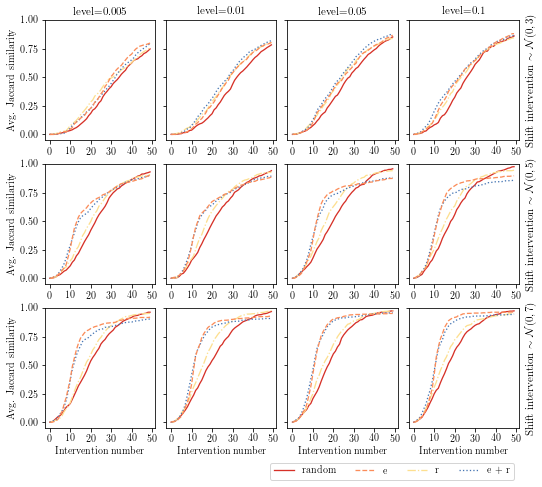

In [13]:
# Plot settings
gs = gridspec.GridSpec(3, 4, wspace=0.10, hspace=0.2)
plt.figure(figsize=(8.5,7.5))

plot_iter = 50
ylim = [-0.05, 1]
linestyle = ['-', '--', '-.', ':']
zorder = [1,4,2,3,-1,-2,-3,-4]
markers = [None]*4#, '^', 's', 'v']#, None,'s', 'v','p']
styleopts = {'linewidth':1.3,
             'markersize':6,
             'markeredgewidth': 0,
             'markevery': 6
            }
plots = zip([Trajectories[i] for i in [0,3,6,9,1,4,7,10,2,5,8,11]],
            levels * 4,
            [strengths[0]] * 4 + [strengths[1]] * 4 + [strengths[2]] * 4)

print("(Mask) Plotting %d/%d experiments" % (len(mask), N*runs))

##############################
# Iterate over different plots
for i, (all_trajectories, level, sample_size) in enumerate(plots):
    plt.subplot(gs[i])
    ax = plt.gca()
    # Plot mean jaccard sim. for each policy
    policies = list(all_trajectories.items())
    policies = [policies[i] for i in [0,2,3,1]]
    for j, (name, policy_trajectories) in enumerate(policies):
        jac_sim = np.array(policy_trajectories)[mask,:]
        ax.plot(jac_sim.mean(axis=0)[0:plot_iter], label=name, marker=markers[j], linestyle = linestyle[j], color=colors[j], zorder=zorder[j], **styleopts)    
    
    # Labels / legend
    plt.ylabel("Avg. Jaccard similarity") if i % 4 == 0 else None
    plt.xlabel("Intervention number") if i >= 8 else None
    ax.set_yticklabels([]) if i % 4 != 0 else None
    #ax.text(0.8,0.05,"i=%d" % i, transform=ax.transAxes, fontsize=11, ha="center")
    if i < 4:
        ax.text(0.5,1.05,"level=%s" % level, transform=ax.transAxes, fontsize=11, ha="center")
    if i % 4 == 3:
        ax.text(1.05,0.5,"Shift intervention $\sim \mathcal{N}(0,%d)$" % sample_size, transform=ax.transAxes, fontsize=11, va="center", rotation=90)
    plt.ylim(ylim)
    ax.set_xticks([0,10,20,30,40,50])
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(1, -.25))
plt.savefig('figures/strength_vs_level.pdf', bbox_inches='tight')